In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem


from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

In [75]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=4, cores=4) #processes=7, cores=7
w = cluster.scale(jobs=5
                 )
#
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.47:8787/status,
Dashboard: http://10.148.1.47:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.47:54054,Workers: 0
Dashboard: http://10.148.1.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p['time']

In [5]:
df

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,waterdepth
npartitions=406,,,,,,,,,,
,int32,float64,float64,float64,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [6]:
lonmin,lonmax = -180,180
latmin,latmax = -60,60

In [7]:
binsize = 2.
lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

In [8]:
num_id = df.groupby(['lon_cut','lat_cut']).count().persist()

In [8]:
num_id = num_id.iloc[:,:2].compute()

In [9]:
num = num_id.reset_index()

In [10]:
num['lon_bins'] = num.lon_cut.apply(lambda x : x.mid)
num['lat_bins'] = num.lat_cut.apply(lambda x : x.mid)

<AxesSubplot:xlabel='lon_bins', ylabel='lat_bins'>

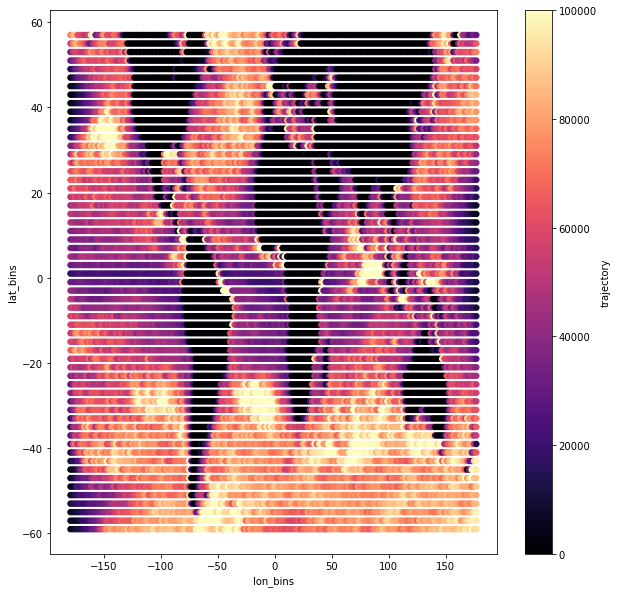

In [11]:
fig,ax = plt.subplots(figsize=(10,10))
num.plot.scatter(x='lon_bins',y='lat_bins',c='trajectory',s=30,cmap='magma',ax=ax,vmax=100000)

In [76]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = ['autocov_demodulation_rr_flag','autocov_demodulation_ri_flag'] #,'autocov_demodulation_ri'
name = ['rr','ri']
df = {}
for i,parcels_id in enumerate(parcels_index):
# choose to select time indexed data for now
    p = pa.parcels_output(root_dir+run_name, parquets=[parcels_id])
#    name = parcels_id[-2:]
    df[name[i]] = p[parcels_id]
df['rr'].head()

,trajectory,time,lon,lat,id,waterdepth,0.0,0.041666666666666664,0.08333333333333333,0.125,...,39.625,39.666666666666664,39.70833333333333,39.75,39.791666666666664,39.83333333333333,39.875,39.916666666666664,39.95833333333333,40.0
0,1000257,40.0,-39.460486,-78.206169,1000257.0,1120.851929,0.000018,0.000018,0.000018,0.000018,...,0.000004,0.000004,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
1,1000257,80.0,-39.802846,-78.161997,1000257.0,0.000000,0.000050,0.000050,0.000050,0.000050,...,-0.000003,-0.000003,-0.000003,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004
2,1000257,120.0,NaN,NaN,1000257.0,0.000000,0.000077,0.000077,0.000077,0.000076,...,-0.000053,-0.000053,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054,-0.000054
3,2000583,40.0,-17.881071,-67.644213,2000583.0,4875.324707,0.000080,0.000080,0.000080,0.000080,...,-0.000026,-0.000027,-0.000027,-0.000028,-0.000028,-0.000029,-0.000029,-0.000030,-0.000030,-0.000031
4,2000583,80.0,-19.424687,-67.616589,2000583.0,0.000000,0.000143,0.000143,0.000143,0.000143,...,-0.000035,-0.000036,-0.000036,-0.000037,-0.000038,-0.000038,-0.000039,-0.000040,-0.000040,-0.000041


In [77]:
for k in df.keys():
    df[k] = df[k].where(df[k].waterdepth>500).persist()

In [78]:
df['rr'].dropna().head()

,trajectory,time,lon,lat,id,waterdepth,0.0,0.041666666666666664,0.08333333333333333,0.125,...,39.625,39.666666666666664,39.70833333333333,39.75,39.791666666666664,39.83333333333333,39.875,39.916666666666664,39.95833333333333,40.0
0,1000257.0,40.0,-39.460486,-78.206169,1000257.0,1120.851929,0.000018,0.000018,0.000018,0.000018,...,0.000004,0.000004,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
3,2000583.0,40.0,-17.881071,-67.644213,2000583.0,4875.324707,0.000080,0.000080,0.000080,0.000080,...,-0.000026,-0.000027,-0.000027,-0.000028,-0.000028,-0.000029,-0.000029,-0.000030,-0.000030,-0.000031
11,2002342.0,40.0,8.341897,-69.187764,2002342.0,2033.399414,0.000186,0.000186,0.000186,0.000186,...,-0.000056,-0.000057,-0.000057,-0.000057,-0.000058,-0.000058,-0.000058,-0.000059,-0.000059,-0.000059
13,3000187.0,40.0,-22.260530,-56.107748,3000187.0,4369.295410,0.000539,0.000539,0.000538,0.000537,...,-0.000086,-0.000092,-0.000097,-0.000103,-0.000108,-0.000113,-0.000118,-0.000123,-0.000127,-0.000132
21,3000275.0,40.0,-19.847146,-60.207234,3000275.0,3619.356201,0.000400,0.000400,0.000401,0.000400,...,-0.000130,-0.000128,-0.000127,-0.000125,-0.000124,-0.000123,-0.000121,-0.000120,-0.000119,-0.000118


In [79]:
lonmin,lonmax = np.around(np.nanmin(df['rr'].lon)),np.around(np.nanmax(df['rr'].lon))
latmin,latmax = np.around(np.nanmin(df['rr'].lat)),np.around(np.nanmax(df['rr'].lat))

In [80]:
lonmin

-201.0

In [81]:
binsize = 2.
def binning(_df,binsize):
    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['id','time','lon','lat','trajectory' ,'waterdepth']) # ,'h'
    _df = _df.rename(columns={c:float(c) for c in _df.columns[:-2]})
    return _df
for k in df.keys():
    df[k] = binning(df[k],binsize).persist()

In [82]:
from dask.distributed import wait
df_mean = {}
for k in df.keys():
    df_mean[k] = df[k].groupby(['lon_cut','lat_cut']).mean().persist()#apply(lambda x: x.mean(skipna=False)).persist()
    df_mean[k] = df_mean[k].reset_index()
df_mean['count'] = df[k].groupby(['lon_cut','lat_cut']).count().persist()

In [83]:
_count = df_mean['count'].reset_index()#.to_dask_array().compute()

In [84]:
_count['lon_bins'] = _count.lon_cut.apply(lambda x :x.mid)
_count['lat_bins'] = _count.lat_cut.apply(lambda x :x.mid)
_count = _count.drop(columns=['lon_cut','lat_cut']).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

In [85]:
_count = _count.to_dask_array().compute()

In [86]:
df_melted = {}
#k = 'rr'
for k in ['rr','ri']:
    df_melted[k] = dd.melt(df_mean[k],id_vars=['lon_cut','lat_cut'],var_name='lags').persist()
    df_melted[k]['lon_bins'] = df_melted[k].lon_cut.apply(lambda x :x.mid)
    df_melted[k]['lat_bins'] = df_melted[k].lat_cut.apply(lambda x :x.mid)
    df_melted[k] = df_melted[k].drop(columns=['lon_cut','lat_cut']).persist()

In [87]:
ds = {}
ds['rr'] = df_melted['rr'].rename(columns={'value': 'rr'}).to_dask_array()
ds['rr'] = ds['rr'].compute()
ds['rr']

array([[0.0, nan, -200.0, -77.0],
       [0.0, nan, -200.0, -75.0],
       [0.0, nan, -200.0, -73.0],
       ...,
       [40.0, nan, 204.0, 65.0],
       [40.0, nan, 204.0, 67.0],
       [40.0, nan, 204.0, 69.0]], dtype=object)

In [88]:
ds['ri'] = df_melted['ri'].rename(columns={'value': 'ri'}).to_dask_array()
ds['ri'] = ds['ri'].compute()
ds['ri']

array([[0.0, nan, -200.0, -77.0],
       [0.0, nan, -200.0, -75.0],
       [0.0, nan, -200.0, -73.0],
       ...,
       [40.0, nan, 204.0, 65.0],
       [40.0, nan, 204.0, 67.0],
       [40.0, nan, 204.0, 69.0]], dtype=object)

In [89]:
ds_out = {}
ds_out['rr'] = xr.Dataset({'rr':(["index"], ds['rr'][:,1])},coords={'lags':(["index"],ds['rr'][:,0]),'lon_bins':(["index"],ds['rr'][:,2]),'lat_bins':(["index"],ds['rr'][:,3])}
                   ).set_index(index = ['lat_bins','lon_bins','lags']).unstack()
ds_out['ri'] = xr.Dataset({'ri':(["index"], ds['ri'][:,1])},coords={'lags':(["index"],ds['ri'][:,0]),'lon_bins':(["index"],ds['ri'][:,2]),'lat_bins':(["index"],ds['ri'][:,3])}
                   ).set_index(index = ['lat_bins','lon_bins','lags']).unstack()

In [90]:
ds_out['count'] = xr.Dataset({'count':(["index"], _count[:,0])},coords={'lon_bins':(["index"],_count[:,-2]),
                                                                    'lat_bins':(["index"],_count[:,-1])}
                        ).set_index(index = ['lat_bins','lon_bins']).unstack()

In [91]:
for k in ds_out.keys():
    ds_out[k] = ds_out[k].astype(np.float64)

In [92]:
_ds = xr.merge([ds_out[k] for k in ds_out.keys()])

In [93]:
_ds

<xarray.Dataset>
Dimensions:   (lat_bins: 74, lon_bins: 203, lags: 961)
Coordinates:
  * lat_bins  (lat_bins) float64 -77.0 -75.0 -73.0 -71.0 ... 63.0 65.0 67.0 69.0
  * lon_bins  (lon_bins) float64 -200.0 -198.0 -196.0 ... 200.0 202.0 204.0
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr        (lat_bins, lon_bins, lags) float64 nan nan nan nan ... nan nan nan
    ri        (lat_bins, lon_bins, lags) float64 nan nan nan nan ... nan nan nan
    count     (lat_bins, lon_bins) float64 0.0 0.0 0.0 5.0 ... 0.0 0.0 0.0 0.0

(-180.0, 180.0)

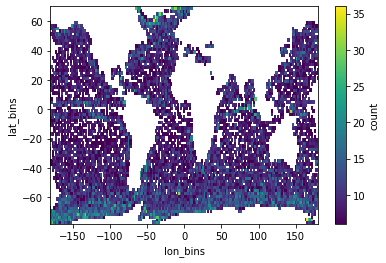

In [94]:
_ds['count'].where(_ds['count']>5).plot(y='lat_bins')
plt.xlim(-180,180)

Text(0.5, 1.0, '')

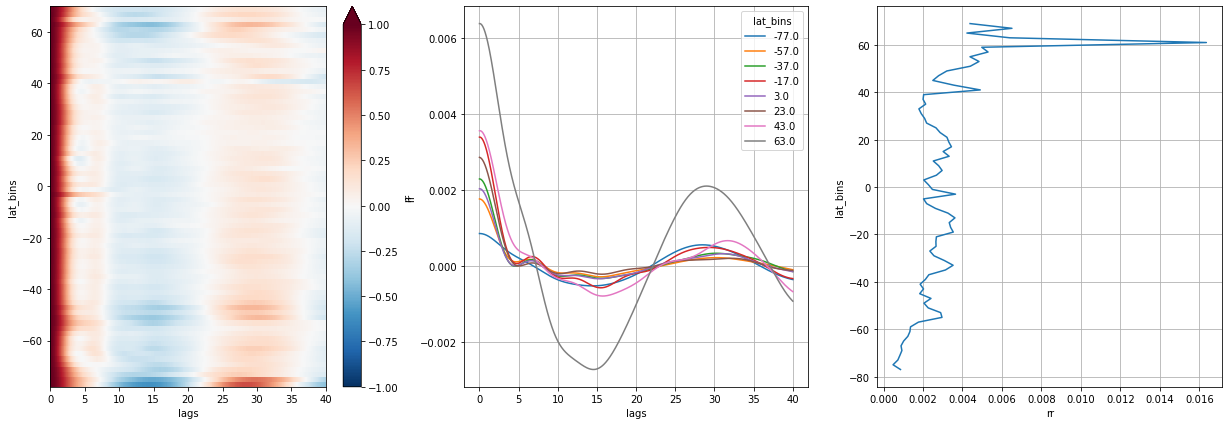

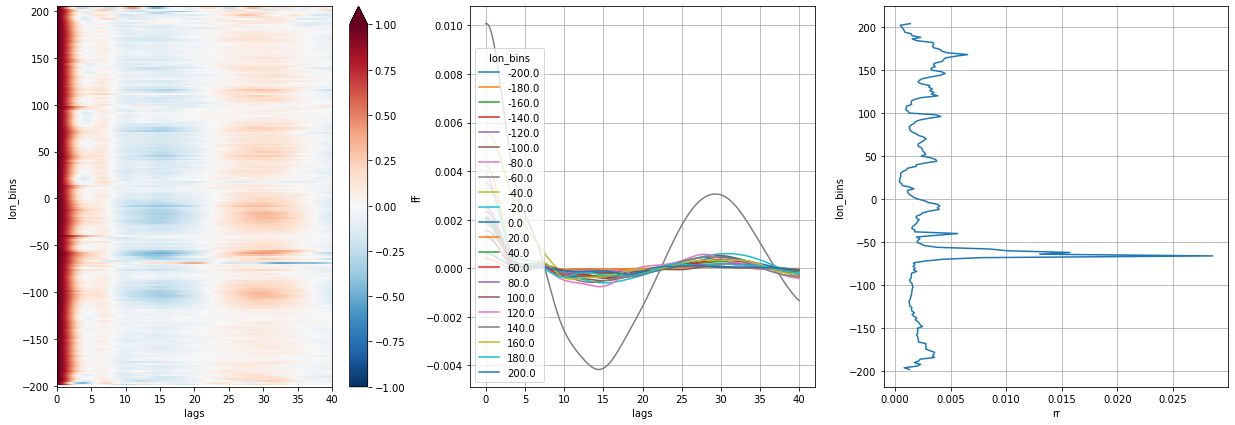

In [95]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.rr.mean('lon_bins')/_ds.rr.mean('lon_bins').isel(lags=0)).plot(ax=ax[0],vmax=1)
(_ds.rr.mean('lon_bins').isel(lat_bins=slice(0,None,10))).plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
_ds.rr.mean('lon_bins').isel(lags=0).plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.rr.mean('lat_bins')/_ds.rr.mean('lat_bins').isel(lags=0)).plot(ax=ax[0],vmax=1)
(_ds.rr.mean('lat_bins').isel(lon_bins=slice(0,None,10))).plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
_ds.rr.mean('lat_bins').isel(lags=0).plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

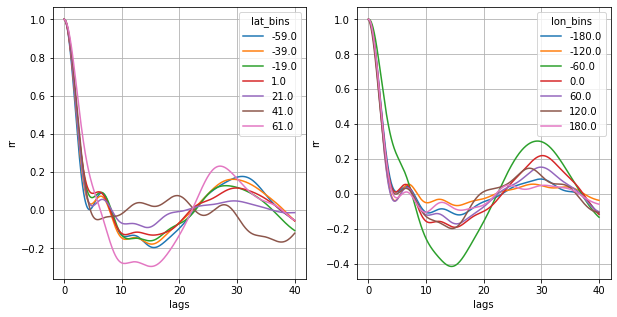

In [96]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
(_ds.rr.mean('lon_bins')/_ds.rr.mean('lon_bins').isel(lags=0)).sel(lat_bins=slice(-60,70,10)).plot(hue='lat_bins',ax=axs[0])
(_ds.rr.mean('lat_bins')/_ds.rr.mean('lat_bins').isel(lags=0)).sel(lon_bins=slice(-180,180,30)).plot(hue='lon_bins',ax=axs[1])
for ax in axs:
    ax.grid()

Text(0.5, 1.0, '')

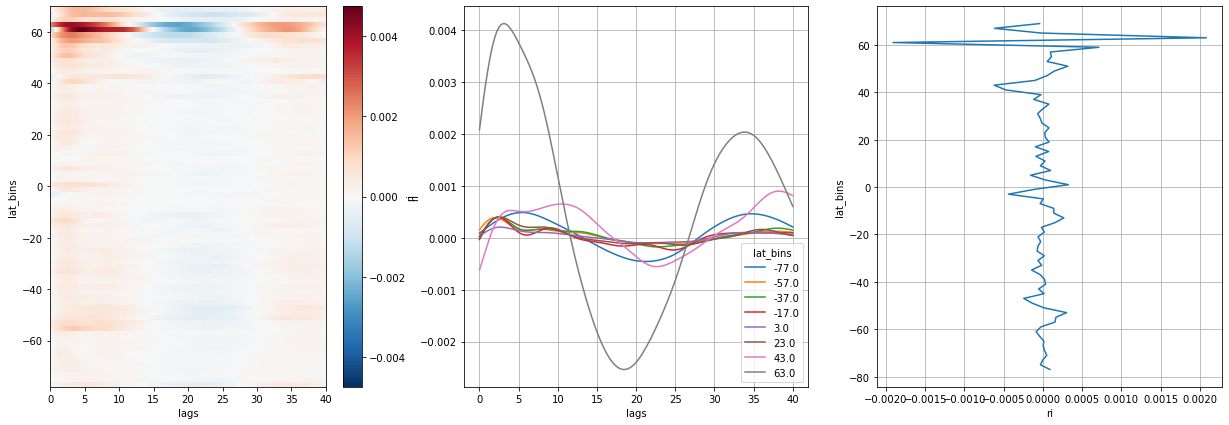

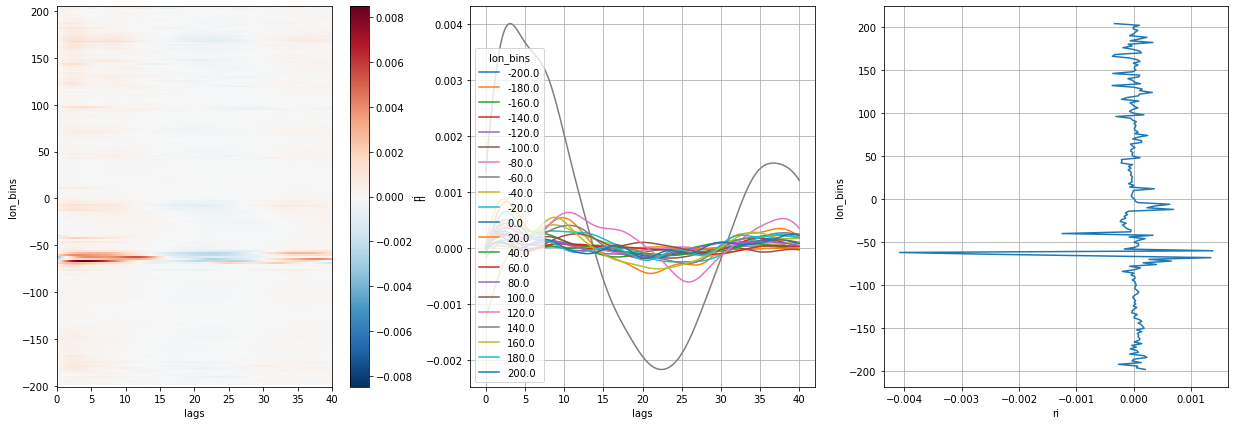

In [97]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.ri.mean('lon_bins')).plot(ax=ax[0])
(_ds.ri.mean('lon_bins').isel(lat_bins=slice(0,None,10))).plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
_ds.ri.mean('lon_bins').isel(lags=0).plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(_ds.ri.mean('lat_bins')).plot(ax=ax[0])
(_ds.ri.mean('lat_bins').isel(lon_bins=slice(0,None,10))).plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
_ds.ri.mean('lat_bins').isel(lags=0).plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

(-180.0, 180.0)

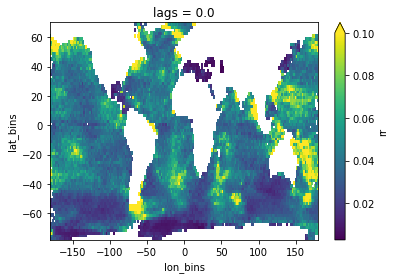

In [98]:
# square root of the autocovariance at lag 0 (~$\widetilde{V})
np.sqrt(_ds.rr.isel(lags=0)).plot(y='lat_bins',vmax=1e-1)
plt.xlim(-180,180)

In [99]:
_ds.attrs.update({'binsize':binsize})
_ds

<xarray.Dataset>
Dimensions:   (lat_bins: 74, lon_bins: 203, lags: 961)
Coordinates:
  * lat_bins  (lat_bins) float64 -77.0 -75.0 -73.0 -71.0 ... 63.0 65.0 67.0 69.0
  * lon_bins  (lon_bins) float64 -200.0 -198.0 -196.0 ... 200.0 202.0 204.0
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr        (lat_bins, lon_bins, lags) float64 nan nan nan nan ... nan nan nan
    ri        (lat_bins, lon_bins, lags) float64 nan nan nan nan ... nan nan nan
    count     (lat_bins, lon_bins) float64 0.0 0.0 0.0 5.0 ... 0.0 0.0 0.0 0.0
Attributes:
    binsize:  2.0

In [100]:
_ = _ds.to_netcdf(path='/home1/datawork/zcaspar/mit4320/binned_Lcov_uu_dl2_flag.nc')

In [101]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
